<a href="https://colab.research.google.com/github/NihilisticMotif/Data-Science-Documentation/blob/main/Data-Science-Documentation/MachineLearning_Algorithm/LogisticRegression/Algorithm/LogisticRegression_01_BinaryLRContinueX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Introduction of Logistic Regression

**What is Logistic Regression?**

Logistic regression is a supervised learning algorithm used to predict a dependent categorical target variable. In essence, if you have a large set of data that you want to categorize, logistic regression may be able to help. (https://www.mastersindatascience.org/learning/machine-learning-algorithms/logistic-regression/)

**Type of Logistic Regression**
1. Binary logistic regression
* This algorithm compute the input $X$ into output $y$, where $y$ only means true or false.
* $y\in \{0,1\}$
* e.g. Is this picture has a dog? etc.
2. Multinomial logistic regression
* e.g.
* Classifying texts into what language they come from.
* Predicting whether a student will go to college, trade school or into the workforce.
* Does your cat prefer wet food, dry food or human food?
* etc.
3. Ordinal logistic regression
* Ordinal logistic regression is also a model where there are multiple classes that an item can be classified as; however, in this case an ordering of classes is required. Classes do not need to be proportionate. The distance between each class can vary.
* e.g. Movies Rate etc.

reference: https://www.mastersindatascience.org/learning/machine-learning-algorithms/logistic-regression/

**Why we do not use linear regression in this case?**

Linear Regression can only be used for predicting the relationship between continuous variable.

This algorithm is not good for classification task because
* In this case, output data can be classify into 2 values $\{0,1\}$, the linear regression algorithmn do not predict output data accuratly at all.
* In theory, $h(x)$ should be $0\leq h(x)\leq 1$ for boolean classification problem.

**What I will do in this tutorial?**
* I will demonstrate how to use Logistic Regression to predict the relationship between continue $x$ variable and discrete $y$ variable.

**Step**
1. Get Data
2. Creating Hypothesis Function
3. Creating Evaluating Function
4. Creating Optimization Function

**Note**
* Both linear regression and logistic regression are linear model.

###Step 1, Getting Data

In [ ]:
!pip install --upgrade -q gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 1.5 MB/s eta 0:00:00


In [ ]:
# [1.] import library

from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math 

# [2.] Connect Google Collab with Google Sheet
from google.colab import auth
import gspread
from google.auth import default
from google.colab import data_table

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('student-mat').get_worksheet(0)
rows = worksheet.get_all_values()
dfmain = pd.DataFrame(rows)

# [3.] Display Data form Google Sheet
dfmain.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
2,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
4,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15


Now we have the data. However we have to reorganize (clean) the data before analyse the data, because computer cannot analyse string data type. In addition, cleaning data help us analyse data more easily.

In [ ]:
# [1.] Get string from the first row of every columns
# reference: https://www.easytweaks.com/get-first-row-pandas-dataframe/
ColumnName = dfmain.iloc[0].to_list()

# [2.] Rename every column
for i in range(len(ColumnName)):
  dfmain.rename(columns={i:ColumnName[i]},inplace=True)

# [3.] Drop first row
dfmain=dfmain.drop([0], axis=0)

# [4.] Change Data Type
# reference: https://www.geeksforgeeks.org/change-data-type-for-one-or-more-columns-in-pandas-dataframe/
# reference: https://statisticsglobe.com/convert-string-boolean-pandas-dataframe-column-python
# reference: https://sparkbyexamples.com/pandas/pandas-convert-column-to-numpy-array/
# reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
# reference: https://stackoverflow.com/questions/2468334/creating-dynamic-and-expandable-dictionaries-in-python
# reference: https://favtutor.com/blogs/merge-dictionaries-python
# reference: https://datagy.io/python-int-to-binary/

# VectorName is used for indicate the meaning of the vector in each categorized data based column
# VectorName = [[ColumnIndex,ColumnDict],...,[ColumnIndex,ColumnDict]]
VectorName=[]

# BinaryVector(lengh) is a function that is used for generate vector
def BinaryVector(lengh):
  mathbbR = math.ceil(math.log2(lengh))
  categorization = []
  for element in range(lengh):
    binary = str(bin(element)).split('b')[1]
    vector = []
    for k in range(mathbbR-len(binary)):
      vector.append(0)
    for i in binary:
      vector.append(int(i))
    categorization.append(vector)
  categorization=np.array(categorization)
  return categorization

# Change the data type of every column in dfmain
for i in range(len(ColumnName)):
  IsD=np.array(dfmain[ColumnName[i]])[0]
  if IsD.isdigit():
    # Change data type from String into Integer
    dfmain[ColumnName[i]]=dfmain[ColumnName[i]].apply(pd.to_numeric)
  else:
    # Change data type from String into Vector that contains 0 and 1
    dfColumn = dfmain[ColumnName[i]].to_numpy()
    ListValue=list(np.sort(pd.Series(np.array(dfColumn)).value_counts().index.to_numpy()))
    # Create Binary Vecotr Dictionary
    Convert = { "data":[]}
    Category=BinaryVector(len(ListValue))
    for j in range(len(ListValue)):
      ConvertData = {}
      ConvertData[ListValue[j]] = Category[j]
      Convert["data"].append(ConvertData)
    for k in range(len(Convert['data'])):
      if (k!=0):
        Convert['data'][k].update(Convert['data'][k-1])
      else:
        continue
    # Update the dfmain and VectorName
    VectorName.append([i,Convert['data'][-1]])
    dfmain[ColumnName[i]] = dfmain[ColumnName[i]].map(dict(Convert['data'][-1]))

In [ ]:
dfmain.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
1,[0],[0],18,[1],[0],[0],4,4,"[0, 0, 0]","[1, 0, 0]",...,4,3,4,1,1,3,6,5,6,6
2,[0],[0],17,[1],[0],[1],1,1,"[0, 0, 0]","[0, 1, 0]",...,5,3,3,1,1,3,4,5,5,6
3,[0],[0],15,[1],[1],[1],1,1,"[0, 0, 0]","[0, 1, 0]",...,4,3,2,2,3,3,10,7,8,10
4,[0],[0],15,[1],[0],[1],4,2,"[0, 0, 1]","[0, 1, 1]",...,3,2,2,1,1,5,2,15,14,15
5,[0],[0],16,[1],[0],[1],3,3,"[0, 1, 0]","[0, 1, 0]",...,4,3,2,1,2,5,4,6,10,10


###Step 2, Creating Hypothesis Function

**Here are the initial variable**

In [ ]:
ind_X=32
ind_Y=20
ColumnNameX=ColumnName[ind_X]
ColumnNameY=ColumnName[ind_Y]
dfmain=dfmain

Note:
* $\theta =\vec{h}$
* Personally, I like $\vec{h}$ than $\theta$ because it makes me realize that $\vec{h}$ is a vector.

**Hypothesis Function**

* $h(\vec{x})=\frac{1}{1 + \exp({-\vec{h}\cdot\vec{x}})}=\frac{1}{1 + e^{-\vec{h}\cdot\vec{x}}}=$ Probability $\in[0,1]$
* $\vec{h}\cdot\vec{x}=\Sigma_{i=0}^nh_ix_i$
* $y=$ real output of the data
* $x_0=1$
* $x_i=$ Input of the data No.$i$
* $h_i=$ constant in hypothesis function No.$i$

**Note: In this case**
* $h(\vec{x})=\frac{1}{1 + \exp(-(x_1*h_1+h_0))}$
* $h(x_1)=$ The probability that the student have Higher_Education (Output)
* $x_1$ = Grade score of the student (Input)

**Output of $h(x)$:**
* $\vec{h}\cdot\vec{x}\geq0\implies h(\vec{x})=\frac{1}{1 + e^{-|\vec{h}\cdot\vec{x}|}}\geq0.5\implies y=1$
* $\vec{h}\cdot\vec{x}<0\implies h(\vec{x})=\frac{1}{1 + e^{|\vec{h}\cdot\vec{x}|}}<0.5\implies y=0$

**Here is the Python implementation**

In [ ]:
def HypothesisFunction(x1,h0,h1):
  return 1/(1+np.exp(-(x1*h1+h0)))

**Q: Why using $e$?**

A: For mathematical simplicity and convenience.
* $e^x=\exp(x)$
* $\frac{d}{dx}[e^x]=e^x$

reference: 
* https://www.quora.com/Why-is-logistic-regression-based-on-the-exponential-function-Where-did-the-exponential-function-come-from-anyway
* https://stats.stackexchange.com/questions/338702/why-do-we-use-the-natural-exponential-in-logistic-regression

###Step3, Creating Evaluation Function

Keyword
* Evaluation Function = Cost Function
* Square Error Function = Evaluation Function of Linear Regression = Cost Function of Linear Regression

**Evaluating Function No.1**

$J(\vec{h})=\frac{1}{m}\Sigma_{i=1}^m C(h(\vec{x}_i),y_i)$

* $y=1\implies C(h(\vec{x}),y)=-\ln(h(\vec{x}))$
* $y=0\implies C(h(\vec{x}),y)=-\ln(1-h(\vec{x}))$

**Evaluating Function No.2**

$J(\vec{h})=-\frac{1}{m}\Sigma_{i=1}^m[y_i*\ln(h(\vec{x}_i))+(1-y_i)\ln(1-h(\vec{x}_i))]$

* $y=1\implies J(\vec{h}))=-\frac{1}{m}\Sigma_{i=1}^m[\ln(h(\vec{x}_i))+0]$
* $y=0\implies J(\vec{h}))=-\frac{1}{m}\Sigma_{i=1}^m[0+\ln(1-h(\vec{x}_i))]$

**Here is the Python implementation**

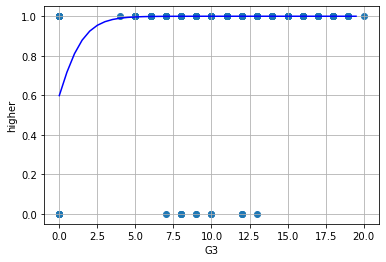

[0.43300614]


In [ ]:
def HypothesisFunction(x1,h0,h1):
  return 1/(1+np.exp(-(x1*h1+h0)))

# 1/(1+np.exp(-(xline*2-3)))

def EvaluationFunction(data,ind_x,ind_y,h0=0,h1=0):
  num=0
  for i in range(data.shape[0]):
    num-=data.iat[i,ind_y]*np.emath.log(HypothesisFunction(data.iat[i,ind_x],h0,h1))+(1-data.iat[i,ind_y])*np.emath.log(1-HypothesisFunction(data.iat[i,ind_x],h0,h1))
  num*=(1/data.shape[0])
  return num

# Here is the data.
# How do I enforce a square grid in matplotlib? reference: https://stackoverflow.com/questions/50158333/how-do-i-enforce-a-square-grid-in-matplotlib
plt.grid()

# Add labels to the x- and y-axis.
plt.xlabel(ColumnNameX)
plt.ylabel(ColumnNameY)

# Data is plotted.
plt.scatter(dfmain[ColumnNameX], dfmain[ColumnNameY])

# Here is the hypothesis function a.k.a. prediction function.
Hi=[0.4,1.055]
xline = np.arange(0, 20,0.5)
yline = HypothesisFunction(xline,Hi[0],Hi[1])

plt.plot(xline, yline, color='blue')

plt.show()

print(EvaluationFunction(dfmain,ind_X,ind_Y,h0=Hi[0],h1=Hi[1]))

**Q: Why doing this? $y=1\implies\ln(h(\vec{x}))$ and $y=0\implies\ln(1-h(\vec{x}))$**

A: 

According to Logarithm: $a^b=c\implies\log_a(c)=b$

$\therefore a^0=1\implies\log_a(1)=0\implies\lim_{c\to1}\log_a(c)=0$

Given that:
* $h(\vec{x})\in[0,1]$
* $h(\vec{x})\geq0.5\implies y=1\implies \ln(h(\vec{x}))\to0$
* $h(\vec{x})<0.5\implies y=0\implies \ln(1-h(\vec{x}))\to0$

**Q: Why we do not use square error function? Why $J(\vec{h})\neq\frac{1}{2m}\sum_{i=1}^m(h(x_i)-y_i)^2$?**

A: $\frac{1}{2m}\sum_{i=1}^m(h(x_i)-y_i)^2$ is not suitable with logistic regression because the value of $y$ is not continueous. If the square error function is ploted on 3D cartesian plane (x-axis=$h_0$, y-axis=$h_1$ and z-axis=error). Then, the function will display multiple local minimums, which interrupt gradient descent from finding the global minimum.

**Q: Why $-(...)$?**

A: 

Given that:
* $h(\vec{x})\in[0,1]$

According to Logarithm: $a^b=c\implies\log_a(c)=b$

$0<a^b=c\leq1\implies \log_a(c)=b\leq0$

$\therefore \frac{1}{m}\Sigma_{i=1}^m[y_i*\log(h(\vec{x}))+(1-y_i)\log(1-h(\vec{x}))]\leq0$

For make things easier, $\frac{1}{m}\Sigma_{i=1}^m[y_i*\log(h(\vec{x}))+(1-y_i)\log(1-h(\vec{x}))]*-1\geq0$

**Q: Why $\ln(x)$?**

A: For mathematical simplicity

* $\frac{d}{dx}[\ln(x)]=\frac1x$

/usr/local/lib/python3.9/dist-packages/numpy/lib/scimath.py:287: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)
<ipython-input-8-845905798b67>:15: RuntimeWarning: invalid value encountered in multiply
  num-=data.iat[i,ind_y]*np.emath.log(HypothesisFunction(data.iat[i,ind_x],h0,h1))+(1-data.iat[i,ind_y])*np.emath.log(1-HypothesisFunction(data.iat[i,ind_x],h0,h1))


Is not a Number=6125
Is a Number=3875


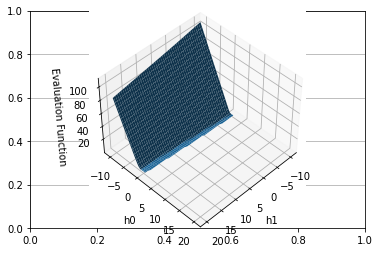

In [ ]:
import math
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure

# Here is the data.
# How do I enforce a square grid in matplotlib? reference: https://stackoverflow.com/questions/50158333/how-do-i-enforce-a-square-grid-in-matplotlib
plt.grid()

def HypothesisFunction(x1,h0,h1):
  return 1/(1+np.exp(-(x1*h1+h0)))

def EvaluationFunction(data,ind_x,ind_y,h0=0,h1=0):
  num=0
  for i in range(data.shape[0]):
    num-=data.iat[i,ind_y]*np.emath.log(HypothesisFunction(data.iat[i,ind_x],h0,h1))+(1-data.iat[i,ind_y])*np.emath.log(1-HypothesisFunction(data.iat[i,ind_x],h0,h1))
  num*=(1/data.shape[0])
  return num

N = 100
M = 100

x_values = np.linspace(-10, 20, N)
y_values = np.linspace(-10, 20, M)

X, Y = np.meshgrid(x_values, y_values)
Z = EvaluationFunction(dfmain,ind_X,ind_Y,h0=X,h1=Y)

# Plotting 3D Data.
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z);

ax.set_xlabel('h1')
ax.set_ylabel('h0')
ax.set_zlabel('Evaluation Function')
ax.view_init(45,45);

def countNaN(arr):
  isnan=0
  isnum=0
  for i in arr:
    for j in i:
      if math.isnan(j)==True:
        isnan+=1
      else:
        isnum+=1
  print('Is not a Number='+str(isnan))
  print('Is a Number='+str(isnum))
countNaN(Z)
# IsNan=6097
# IsNum=3903

**Why graph show only half of a function?**

Note that:
* $a\in\mathbb{R}, \log_a(0)=$ Undefined
* $\lim_{h\to0}\log_a(h)=$ Undefined because there are no values to the left of 0 in the domain of $\log_a(h)$ (reference: https://www.mathway.com/Calculus)


###Step 4, Create Optimization Function using Gradient Descent

**[1.] Gradient descent of logistic repression**

Gradient descent is an optimization algorithm which is used for minimizing error value of the evaluation function

$h_j:=h_j-a*\frac{\partial}{\partial h_j}J(h_j)$
* $h_j=$ variable in hypothesis function
* $a=$ learning rate
* $J(h_j)=$ Evaluation Function.
* $\frac{\partial}{\partial h_j}J(h_j)=$ Partial derivative of Evaluation Function with respect to variable $h_j$
* $0\leq j <n$

Gradient descent in logistic repression works the same ways as in linear regression. In other words, it minimizes the error (find the global minimum.) of the evaluation function.

**[2.] Find $\frac{\partial}{\partial h_j}[h(h_j)]=\frac{\partial}{\partial h_j}[\frac{1}{1+\exp(-x*h_j-c)}]$**

Note:
* $h_j=$ constant $\in\vec{h}$ = constant in hypothesis function of Logistic Regression algorithm.
* $h(\vec{h},\vec{x})=$ hypothesis function of Logistic Regression algorithm.
* $\vec{x}=$ Input
* $\vec{x},\vec{h}\in\mathbb{R}^{n+1}$
* $g_a(g_{\text{len}}(x))=g_a(g_{a+1}(...(g_{\text{len}}(x)))), \text{len}=$ number of all function

Given that:

\begin{bmatrix}
f(h_j) & = & h_j^{-1} &\implies & f'(h_j)&=&-h_j^{-2}
&\text{&}&  f'(g_{\text{len}}(h_j))&=&-(\exp(-x*h_j-c)+1)^{-2}\\
g_1(h_j) & = & h_j+1    &\implies&g_1'(h_j)&=&1      
&\text{&}&g_1'(g_{\text{len}}(h_j))&=&1\\
g_2(h_j) & = & e^{h_j}    &\implies&g_2'(h_j)&=&e^{h_j}   
&\text{&}&g_2'(g_{\text{len}}(h))&=&\exp(-x*h_j-c)\\
g_3(h_j) & = & -x*h_j-c &\implies&g_3'(h_j)&=&-x     
&\text{&}&g_3'(g_{\text{len}}(h_j))&=&-x
\end{bmatrix}

According to Chain Rule: $\frac{d}{dx}[f(g(x))] = (f\circ g)'= f'(g(x))*g'(x)$

$\therefore\frac{\partial}{\partial h_j}[\frac{1}{1+\exp(-x*h_j-c)}]=
-(\exp(-x*h_j-c)+1)^{-2}
*1
*\exp(-x*h_j-c)
*(-x)
$

$\frac{\partial}{\partial h_j}[\frac{1}{1+\exp(-x*h_j-c)}]=
(\exp(-x*h_j-c)+1)^{-2}
*\exp(-x*h_j-c)
*x
$

$\frac{\partial}{\partial h_j}[\frac{1}{1+\exp(-x*h_j-c)}]=
\frac{x*\exp(-x*h_j-c)}{(\exp(-x*h_j-c)+1)^2}
$

$\frac{\partial}{\partial h_j}[\frac{1}{1+\exp(-x*h_j-c)}]=
\frac{x-x+x*\exp(-x*h_j-c)}{(\exp(-x*h_j-c)+1)^2}
$

$\frac{\partial}{\partial h_j}[\frac{1}{1+\exp(-x*h_j-c)}]=
\frac{x+x*\exp(-x*h_j-c)}{(\exp(-x*h_j-c)+1)^2}
-\frac{x}{(\exp(-x*h_j-c)+1)^2}
$

$\frac{\partial}{\partial h_j}[\frac{1}{1+\exp(-x*h_j-c)}]=
\frac{x}{(\exp(-x*h_j-c)+1)}*(
\frac{1+\exp(-x*h_j-c)}{(\exp(-x*h_j-c)+1)}
-\frac{1}{(\exp(-x*h_j-c)+1)})
$

$\frac{\partial}{\partial h_j}[\frac{1}{1+\exp(-x*h_j-c)}]=
\frac{x}{(\exp(-x*h_j-c)+1)}*(
1
-\frac{1}{(\exp(-x*h_j-c)+1)})
$

Given that: $h(h_j)=\frac{1}{1+\exp(-x*h_j-c)}$

$\therefore\frac{\partial}{\partial h_j}[h(h_j)]=
x*h(h_j)*(
1
-h(h_j))
$

Note: 
* In this case, $x$ is the coefficient of the $h_j, \implies x=x_j$
* $\frac{\partial}{\partial h_j}[h(\vec{h},\vec{x})]=x_j*h(\vec{h},\vec{x})*(1-h(\vec{h},\vec{x}))$

reference: https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d

**[3.] Find $\frac{d}{dx}[\log_a(g(x))]$**

Given that:
* $f(x)=\log_a(x)\implies f'(x)=\frac{1}{\ln(a)*x}$
* $g(x)$

According to Chain Rule: $\frac{d}{dx}[f(g(x))] = (f\circ g)'= f'(g(x))*g'(x)$

$\therefore\frac{d}{dx}[\log_a(g(x))]=\frac{g'(x)}{\ln(a)*g(x)}$

**[4.] Hypothesis Function in Matrix Form**

* $h(\vec{x})\in[0,1]$
* $h(\vec{x}) =\frac{1}{1 + e^{-\vec{h}\cdot\vec{x}}}=\frac{1}{1 + \exp({-\vec{h}\cdot\vec{x}})}=$ Probability

**[5.] Finding $\frac{\partial}{\partial h_j}J(h_j)$**

Given that:
* $\frac{\partial}{\partial h_j}[J(\vec{h})]=-\frac{1}{m}\Sigma_{i=1}^m[y_i*\ln(h(\vec{x}_i))+(1-y_i)\ln(1-h(\vec{x}_i))]$

According to derivative to Sum Rule: $\frac{d}{dx}[f(x)+g(x)] = \frac{d}{dx}f(x)+\frac{d}{dx}g(x)$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  \frac{\partial}{\partial h_j}[y_i*\ln(h(\vec{x}_i))]
  +\frac{\partial}{\partial h_j}[(1-y_i)\ln(1-h(\vec{x}_i))]
  ]$

According to Constant multiple rule No.1, $\frac{d}{dx}[k*f(x)] = k*\frac{d}{dx}f(x)$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  y_i*\frac{\partial}{\partial h_j}[\ln(h(\vec{x}_i))]
  +(1-y_i)*\frac{\partial}{\partial h_j}[\ln(1-h(\vec{x}_i))]
  ]$

Given that:
* $\frac{d}{dx}[\log_a(g(x))]=\frac{g'(x)}{\ln(a)*g(x)}$
* $\ln(e)=1$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  y_i*\frac{\frac{\partial}{\partial h_j}[h(\vec{x}_i)]}{h(\vec{x}_i)}
  +(1-y_i)*\frac{\frac{\partial}{\partial h_j}[1-h(\vec{x}_i)]}{1-h(\vec{x}_i)}
  ]$

Given that:
* $\frac{\partial}{\partial h_j}[h(h_j)]=x_j*h(h_j)*(1-h(h_j))$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  y_i*\frac{x_j*h(h_j)*(1-h(h_j))}{h(\vec{x}_i)}
  +(1-y_i)*\frac{-x_j*h(h_j)*(1-h(h_j))}{1-h(\vec{x}_i)}
  ]$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  y_i*\frac{x_j*h(h_j)*(1-h(h_j))}{h(\vec{x}_i)}
  -(1-y_i)*\frac{x_j*h(h_j)*(1-h(h_j))}{1-h(\vec{x}_i)}
  ]$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  y_i*x_j*(1-h(h_j))
  -(1-y_i)*x_j*h(h_j)
  ]$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  y_i*x_j
  -y_i*x_j*h(h_j)
  -x_j*h(h_j)
  +y_i*x_j*h(h_j)
  ]$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  y_i*x_j
  -x_j*h(h_j)
  ]$

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  x_j*(y_i
  -h(h_j))
  ]$

**[6.] Convert $\frac{\partial}{\partial h_j}[J(\vec{h})]$ in to matrix from**

$\frac{\partial}{\partial h_j}[J(\vec{h})]=
-\frac{1}{m}
\Sigma_{i=1}^m[
  x_j*(y_i
  -h(h_j))
  ]$

Given that: for $n =$ number of all features of the training data
* $h(\vec{h},\vec{x})=\frac{1}{1 + \exp({-\vec{h}\cdot\vec{x}})}$
* $\vec{h}:=\vec{h}-a*\frac{\partial}{\partial \vec{h}}J(\vec{h})$
* $\frac{\partial}{\partial \vec{h}}[J(\vec{h})],\vec{h},\vec{x}\in\mathbb{R}^{n+1}, x_0=1$

Given that: for $m =$ number of all training data
* $\vec{y},h(X)\in\mathbb{R}^{m}$

Given that: for $h(x)$
* $h(\vec{x})\in\mathbb{R}$
* $X\in\mathbb{R}^{m\times (n+1)}, \text{$X$ contains several $\vec{x}$.}$

Given that:
* According to transpose: $X^T\in\mathbb{R}^{(n+1)\times m}$
* $\vec{y}-h(X),\vec{y},h(X)\in\mathbb{R}^{m\times 1}$

According to matric multiplication: $A\in\mathbb{R}^{m\times n},B\in\mathbb{R}^{n\times p}\implies AB\in\mathbb{R}^{m\times p}$

$\therefore\frac{\partial}{\partial \vec{h}}[J(\vec{h})]=
-\frac{1}{m}*X^T*(\vec{y}-h(X))$

**[7.] Gradient Descent in matrix form**

Given that:
* $h_j:=h_j-a*\frac{\partial}{\partial h_j}J(h_j)$
* $\vec{h}\in\mathbb{R}^{n+1}$


$\therefore \vec{h}:=\vec{h}-a*\frac{\partial}{\partial \vec{h}}J(\vec{h})$

Given that:
* $\frac{\partial}{\partial \vec{h}}[J(\vec{h})]=-\frac{1}{m}*X^T*(\vec{y}-h(X))$

$\therefore \vec{h}:=\vec{h}-a*(-\frac{1}{m}*X^T*(\vec{y}-h(X)))$

$\vec{h}:=\vec{h}+\frac{a}{m}*X^T*(\vec{y}-h(X))$


In [ ]:
def HypothesisFunction(x1,h0,h1):
  return 1/(1+np.exp(-(x1*h1+h0)))

def diff_EvaluationFunction(x, y, h):
    return np.array([-(y-HypothesisFunction(x,h[0],h[1])).mean(), (-(y-HypothesisFunction(x,h[0],h[1]))*x).mean()]).reshape(-1)

def gradient_descent(
    gradient,         # derivative of EvaluationFunction
    x, 
    y, 
    start,            # initial value of hypothesis function
    learn_rate=0.1,   # a
    n_iter=50,        # maximum time that the model loop
    tolerance=1e-06   # when the model stop the loop
):
    vector = start
    for _ in range(n_iter):
        diff = -learn_rate * np.array(gradient(x, y, vector))
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
    return vector

h_i=gradient_descent(
    diff_EvaluationFunction, dfmain[ColumnNameX], dfmain[ColumnNameY], start=[0.5, 0.5], learn_rate=0.0008,
    n_iter=100_000
)
print(h_i)

# 9 minutes

[1.32865499 0.17638434]


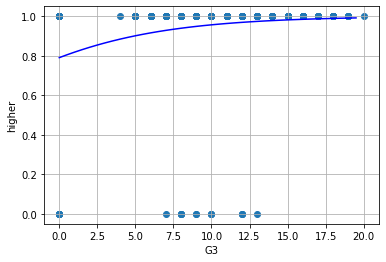

[0.18624363]


In [ ]:
def HypothesisFunction(x1,h0,h1):
  return 1/(1+np.exp(-(x1*h1+h0)))

def EvaluationFunction(data,ind_x,ind_y,h0=0,h1=0):
  num=0
  for i in range(data.shape[0]):
    num-=data.iat[i,ind_y]*np.emath.log(HypothesisFunction(data.iat[i,ind_x],h0,h1))+(1-data.iat[i,ind_y])*np.emath.log(1-HypothesisFunction(data.iat[i,ind_x],h0,h1))
  num*=(1/data.shape[0])
  return num

# Here is the data.
# How do I enforce a square grid in matplotlib? reference: https://stackoverflow.com/questions/50158333/how-do-i-enforce-a-square-grid-in-matplotlib
plt.grid()

# Add labels to the x- and y-axis.
plt.xlabel(ColumnNameX)
plt.ylabel(ColumnNameY)

# Data is plotted.
plt.scatter(dfmain[ColumnNameX], dfmain[ColumnNameY])

# Here is the hypothesis function a.k.a. prediction function.
xline = np.arange(0,20,0.5)
yline = HypothesisFunction(xline,h_i[0],h_i[1])

plt.plot(xline, yline, color='blue')
plt.show()

print(EvaluationFunction(dfmain,ind_X,ind_Y,h0=h_i[0],h1=h_i[1]))

In [ ]:
print(xline)
print(yline)

[ 0 20]
[0.79061807 0.99228115]


###Bonus No.1: Common Python Technique

**1. How to add all number in a column of a data frame?**

In [ ]:
# method no.1
#print(data.sum())

# method no.2
def Sigma(data,ind_x):
  num=0
  # len(data.axes[0]) = number of all row of the data
  for i in range(data.shape[0]):
    # data.iat[row,column] = Get a element from dataframe matrix
    # In this case, get all element from the first column via for-loop.
    num+=data.iat[i,0]
  return num

print(Sigma(dfmain,ind_X))

4232


###Bonus No.2: Matrix Multiplication

* Used for linear transformations algorithmn
* Used for finding total value of somethings, e.g. total income in each months. etc.

**Purpose:**
1. Matrix Multiplication used for finding scalar value of each row of the first matrix multiplied by multiple set of variable from column of second matrix.

for example

Finding money made in each day from day/product table and price/product table. (https://youtu.be/fRv3-LnEUjg)

etc.

2. Finding return value given the linear transformation and the input vector.

**Matrix Multiplied by Matrix**

Given that:
* $1\leq i \leq m$
* $1\leq j \leq p$
* $1\leq k \leq n$
* $A\in\mathbb{R}^{m\times n}$
* $B\in\mathbb{R}^{n\times p}$
* $\implies AB\in\mathbb{R}^{m\times p}$
* $\implies AB_{i,j}=\Sigma_{k=1}^nA_{i,k}*B_{k,j}$

reference: https://en.wikipedia.org/wiki/Matrix_multiplication

**How to find the product of 2 matrix?**

* 2 Matrix can be multiplied by each other if their dimensions are compatible , which means the number of columns in the first matrix is the same as the number of rows in the second matrix.
* $A \in \mathbb{R}^{m \times n}$
* $B \in \mathbb{R}^{n \times p}$

$A=$
 $\begin{pmatrix}
a_{1,1} & a_{1,2} & ... & a_{1,n}\\
a_{2,1} & a_{2,2} & ... & a_{2,n}\\
... & ... & ... & ... &\\
a_{m,1} & a_{m,2} & ... & a_{m,n}
\end{pmatrix}$

$B=$
 $\begin{pmatrix}
b_{1,1} & b_{1,2} & ... & b_{1,p}\\
b_{2,1} & b_{2,2} & ... & b_{2,p}\\
... & ... & ... & ... &\\
b_{n,1} & b_{n,2} & ... & b_{n,p}
\end{pmatrix}$

$A*B=AB=$
 $\begin{pmatrix}
a_{r1}\cdot b_{c1} & a_{r1}\cdot b_{c2} & ... & a_{r1}\cdot b_{cp}\\
a_{r2}\cdot b_{c1} & a_{r2}\cdot b_{c2} & ... & a_{r2}\cdot b_{cp}\\
... & ... & ... & ... &\\
a_{rm}\cdot b_{c1} & a_{rm}\cdot b_{c2} & ... & a_{rm}\cdot b_{cp}
\end{pmatrix}$

Given that $a_{ri} = (a_{i,1}, a_{i,2}, ..., a_{i,n})$, and $b_{cj} = (b_{1,j}, b_{2,j}, ..., b_{n,j})$

It is noteworthly that $AB\in\mathbb{R}^{m\times p}$

**Properties of Matrix Multiplication**

* $A*B\neq B*A$
* $(AB)C=A(BC)$
* $A(B+C)=AB+AC$
* $A$ is $m\times n$ matrix and $I$ is a identical matrix $\implies I_mA = AI_n=A$
* $O$ is a zero matrix $\implies O*A=A*O=O$
* $\{m\times n \text{ matrix}\}*\{n\times k \text{ matrix}\} = \{m\times k \text{ matrix}\}$

reference: https://www.khanacademy.org/math/precalculus/x9e81a4f98389efdf:matrices/x9e81a4f98389efdf:properties-of-matrix-multiplication/a/properties-of-matrix-multiplication

**Prove that $A*B\neq B*A$**

Given that
* $A \in \mathbb{R}^{m \times n}$
* $B \in \mathbb{R}^{n \times p}$
* $\vec{A_r}$ is row vector of $A \implies 1 \leq r \leq m$
* $\vec{B_c}$ is column vector of $B \implies 1 \leq c \leq p$

$\therefore AB=\{\vec{A_r}\cdot \vec{B_c}\}=$
 $\begin{pmatrix}
\vec{A_1}\cdot \vec{B_1} & ... & \vec{A_1}\cdot \vec{B_p}\\
... & ... & ... \\
\vec{A_m}\cdot \vec{B_1} & ... & \vec{A_m}\cdot \vec{B_p}
\end{pmatrix}$

**Finding the value of $BA$**

Given that
* $A \in \mathbb{R}^{m \times n}$
* $B \in \mathbb{R}^{n \times p}$
* $\vec{A_d}$ is column vector of $A \implies 1 \leq r \leq n$
* $\vec{B_q}$ is row vector of $B \implies 1 \leq c \leq n$

$\therefore BA=\{\vec{B_q}\cdot \vec{A_d}\}=$
 $\begin{pmatrix}
\vec{B_1}\cdot \vec{A_1} & ... & \vec{B_1}\cdot \vec{A_n}\\
... & ... & ... \\
\vec{B_n}\cdot \vec{A_1} & ... & \vec{B_n}\cdot \vec{A_n}
\end{pmatrix}$

$\therefore BA\in\mathbb{R}^{n\times n}\implies AB\neq BA$

**Prove that: $\vec{a}*\vec{b}^T=\vec{b}*\vec{a}^T=\vec{a}\cdot\vec{b}\in \mathbb{R}$**

Given that
* $\vec{a},\vec{b}\in\mathbb{R}^{n\times1}\implies\vec{a}^T,\vec{b}^T\in\mathbb{R}^{1\times n}$

According to matrix multiplication property: $\{m\times n \text{ matrix}\}*\{n\times k \text{ matrix}\} = \{m\times k \text{ matrix}\}$

$\therefore \{1\times n \text{ matrix}\}*\{n\times 1 \text{ matrix}\} = \{1\times 1 \text{ matrix}\}$

$\therefore \vec{a}*\vec{b}^T=\vec{b}*\vec{a}^T=\vec{a}\cdot\vec{b}\in \mathbb{R}$

reference: 
* https://math.stackexchange.com/questions/1853808/product-of-a-vector-and-its-transpose-projections

**Warning: $\vec{v}^T*\vec{u}\neq\vec{v}\cdot\vec{u}$**

Given that
* $\vec{v}=\begin{pmatrix}
v_1\\
...\\
v_n
\end{pmatrix}$
* $\vec{v}^T=\begin{pmatrix}
v_1&
...&
v_n
\end{pmatrix}$

* $\vec{u}=\begin{pmatrix}
u_1\\
...\\
u_n
\end{pmatrix}$

$\vec{v}\cdot\vec{u}=\Sigma_{i=0}^nv_iu_i$

$\vec{v}^T*\vec{u}=\begin{pmatrix}
u_1\cdot v_1&...&u_1\cdot v_n\\
...&...&...\\
u_n\cdot v_1&...&u_n\cdot v_n
\end{pmatrix}\implies \vec{v}\cdot\vec{u}\neq\vec{v}^T*\vec{u}$

reference: 
* https://www.facebook.com/photo/?fbid=1270919696801619&set=gm.1557918844650634&idorvanity=262423460866852

**Prove that $A*B\neq B*A$**

Given that
* $A\in\mathbb{R}^{m\times n}$
* $B\in\mathbb{R}^{n\times p}$
* $A_i=(a_{i1},...,a_{in})$
* $B_j=(a_{1j},...,a_{nj})$

$A*B=(A_i\cdot B_j)$

$B*A=(A_i\cdot B_j)$

**Dividing matrix by vector**

* $A=\begin{bmatrix}
a_{1,1} & ... & a_{1,n}\\
...&...&...\\
a_{m,1} & ... & a_{m,n}
\end{bmatrix}=\begin{bmatrix}
\vec{a_{1}}^T \\
... \\
 \vec{a_{m}}^T
\end{bmatrix}\in\mathbb{R}^{m\times n}\implies \vec{a_{1}},...,\vec{a_{m}}\in\mathbb{R}^{1\times n}$
* $\vec{x}\in\mathbb{R}^{1\times n}$

$A\vec{x}=\begin{bmatrix}
x_1*a_{1,1} + ... + x_n*a_{1,n}\\
...\\
x_1*a_{m,1} + ... + x_n*a_{m,n}
\end{bmatrix}=\begin{bmatrix}
\vec{x}\cdot\vec{a}_1\\
...\\
\vec{x}\cdot\vec{a}_m\\
\end{bmatrix}\implies A\vec{x}\in\mathbb{R}^{m\times 1}$

In [ ]:
n=10

mx0= np.array([
    dfM[2].head(n),
    dfM[6].head(n),
    dfM[7].head(n),
    dfM[12].head(n)
    ])

mx1= np.array([
    dfM[12].head(n),
    dfM[13].head(n),
    dfM[14].head(n),
    dfM[24].head(n)
    ])

result = [[0,0,0,0],
         [0,0,0,0],
         [0,0,0,0]]

mx1t=mx1.transpose()

print(mx0)

print(mx1t)

answer=[]
for row in range(len(mx0)):
  result=0
  #print(mx0[row])
  for column in range(len(mx1t)):
    result+=mx1t[column][row]*mx0[row][column]
    #print(mx1t[column][row])
    #print(mx0[row][column])
  answer.append(result)

print(answer)

ans=np.array(answer)
print(ans)

[[18 17 15 15 16 16 16 17 15 15]
 [ 4  1  1  4  3  4  2  4  3  3]
 [ 4  1  1  2  3  3  2  4  2  4]
 [ 2  1  1  1  1  1  1  2  1  1]]
[[2 2 0 3]
 [1 2 0 3]
 [1 2 3 3]
 [1 3 0 2]
 [1 2 0 3]
 [1 2 0 4]
 [1 2 0 4]
 [2 2 0 1]
 [1 2 0 2]
 [1 2 0 5]]
[195, 62, 3, 34]
[195  62   3  34]


reference:
* https://youtu.be/fRv3-LnEUjg

###Bonue No.3: T-Test

[0.94936709]
10.415189873417722


<ipython-input-16-935c68ba75af>:21: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(line,(line/line)*dfmain[ColumnNameY].mean(),color='blue')
<ipython-input-16-935c68ba75af>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(line,(line/line)*dfmain[ColumnNameX].mean(),color='red')


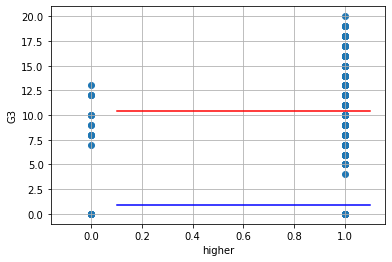

In [ ]:
def HypothesisFunction(x1,h0,h1):
  return 1/(1+np.exp(-(x1*h1+h0)))

def EvaluationFunction(data,ind_x,ind_y,h0=0,h1=0):
  num=0
  for i in range(data.shape[0]):
    num-=data.iat[i,ind_y]*np.emath.log(HypothesisFunction(data.iat[i,ind_x],h0,h1))+(1-data.iat[i,ind_y])*np.emath.log(1-HypothesisFunction(data.iat[i,ind_x],h0,h1))
  num*=(1/data.shape[0])
  return num

plt.grid()

# The Data
plt.xlabel(ColumnNameY)
plt.ylabel(ColumnNameX)
plt.scatter(dfmain[ColumnNameY], dfmain[ColumnNameX])

# The mean of the data
line=np.arange(-0.1,1.1,0.1)
print(dfmain[ColumnNameY].mean())
plt.plot(line,(line/line)*dfmain[ColumnNameY].mean(),color='blue')
print(dfmain[ColumnNameX].mean())
plt.plot(line,(line/line)*dfmain[ColumnNameX].mean(),color='red')

plt.show()

**What is T Test?**
* A statistical test that is used to compare the means of two groups.

**T Test Formula:** $y_{\text{test}}=\text{mean}_{0}*B_0+(\text{mean}_{1}-\text{mean}_{0})*B_1=\text{mean}_{0}*B_0+\Delta\text{mean}*B_1$

* $y_{\text{test}}=$ T Test result
* $\text{mean}_0=$ average value of $y$ when $x=0$
* $\text{mean}_1=$ average value of $y$ when $x=1$
* $B_0=$ coefficient that turn on $\text{mean}_{0}$
* $B_1=$ coefficient that turn off or on $\text{mean}_{1}$ depending on the data

**Note**
* The blue line = $\text{mean}_0$
* The red line = $\text{mean}_1=\text{mean}_0+\Delta\text{mean}*B_1$

**T Test in Matrix Form**
* The data can be represented as matrix
* $y_{\text{test}}=\begin{bmatrix}
\text{mean}_{0}*\vec{B_0} & (\text{mean}_{1}-\text{mean}_{0})*\vec{B_1}\\
\end{bmatrix}\in\mathbb{R}^{m\times2}$
* $\vec{B_0},\vec{B_1}\in\mathbb{R}^m,m=$ number of all data $\in\mathbb{Z}^+$

**Why doing this?**
* We are testing if $\text{mean}_{1}-\text{mean}_{0}=0$ or not?
* If $\text{mean}_{1}-\text{mean}_{0}=0\implies$ your data matches the null hypothesis and there are no irregularities found.
* null hypothesis = The hypothesis that there is no significant difference between specified populations, any observed difference being due to sampling or experimental error.

**Here is the Python implementation**

In [ ]:
print()

###Reference:
* https://www.coursera.org/learn/machine-learning-course/lecture/wlPeP/classification
* https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc
* https://youtu.be/yIYKR4sgzI8
* https://realpython.com/logistic-regression-python/